## Video Grab

Grap a live video from a webcam, crop the frams and display them,

### Overview
When the  video tag has a href pointing to  *file*.m3u8 link down through them until you get to file 
that has .ts file - this is the video images. The .m3u8 is a index to the video, it can be multi-level index
index of resolutition poiinting to index of chunks. Linking down you will get different resolution.
The .ts are chunks that can be fetched. Neat trick allows start in high resolution, if badwidth 
drops use lower resolution, each element on the list start at the same place, switching resolutions
are synced. Do the preparation of the encoding before, can have multiple users access the same 
content at different point. Thi

- all the camera : http://cwwp2.dot.ca.gov/vm/iframemap.htm 

- selected camera : http://cwwp2.dot.ca.gov/vm/loc/d3/hwy80atapplegate.htm 
Extracted values from 
- list of the http://wzmedia.dot.ca.gov:1935/D3/80_applegate.stream/chunklist_w26198038.m3u8
- 

In [ ]:
#!pip install m3u8
#!pip install opencv-python

In [1]:
import string
import os
import sys
import json
import base64
import ssl
import time
import datetime
import io
import logging
import re
import collections

import cv2
import requests
import urllib
import m3u8
from urllib.parse import urlparse
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
from IPython.display import clear_output

from interactivecrop.interactivecrop import main as crop

if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')

import stream_video as video

## Tutorial 
A very good walk through on the .m3u8 files that index .ts files that have 
the vido chunks that we need 

https://www.youtube.com/watch?v=bytnxnZFLeg


## test file access
The .ts files have the images to analyize. You need to walk through the index to get to the data. Mulitple index formats. Not sure if thier standard method for the schema, may make it too easy to 'borrow' someone ele's content.


"blob:https://www.earthcam.com/00631398-95e6-40df-9d75-71501c1a6da6"

<video muted="muted" crossorigin="anonymous" id="videoPlayer_html5_api" class="vjs-tech" preload="none" style="position: absolute" tabindex="-1" src="blob:https://www.earthcam.com/00631398-95e6-40df-9d75-71501c1a6da6"></video>



# Locating the chunks.

The live webcams have a hierachy of files that terminates with files with chunks of frames, .ts files. 
The deepest .m3u8 will be updated with every new chunk's arrival. Work your way down to the lowests m3u8 file handle, this file is newly captured .ts files, it gets rewritten with new video chunks arrive. 

Below is collection of sites that we can fetch video via .m3u8 that reference .ts files. 

The standard process is to find a webcam that you are interested in getting the contents from, using 
Chome to look a the network traffic looking for files being fetched that end inf '.m3u8', repeatily. 
Look at the preview, you have the correct file if you see content refering to .ts files like this...
```text
#EXTM3U
#EXT-X-VERSION:3
#EXT-X-MEDIA-SEQUENCE:4982
#EXT-X-TARGETDURATION:12
#EXTINF:11.989,
hr_zadar4-4982.ts
#EXTINF:11.986,
hr_zadar4-4983.ts
#EXTINF:11.989,
hr_zadar4-4984.ts
```

Capture the url link to the file in chrome and past into M3U8 variable in below. 
https://cdn-004.whatsupcams.com/hls/hr_zadar4.m3u8

Below you will find the video link and M3U8 for webcam at different sites

### whatsupcams 
| url | M3U8 |
|:-----|:-----|
|https://www.whatsupcams.com/en/webcams/croatia/zadar/zadar/zadar-narodni-trg-peoples-square/| https://cdn-004.whatsupcams.com/hls/hr_zadar4.m3u8|
| https://www.whatsupcams.com/en/webcams/italy/veneto/venice/webcam-venice-rialto-bridge/ | https://cdn-001.whatsupcams.com/hls/it_venezia01.m3u8| 
| https://www.whatsupcams.com/en/webcams/croatia/zadar/zadar/zadar-trg-petra-zoranica/ | https://cdn-001.whatsupcams.com/hls/hr_zadar3.m3u8 |

        

### caltrans

| url | M3U8 |
|:-----|:-----|
|http://cwwp2.dot.ca.gov/vm/loc/d4/tv388sr1justsouthofpresidiotunnel.htm| http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/chunklist_w665039362.m3u8 |
| http://cwwp2.dot.ca.gov/vm/loc/d4/tv457sr92elcaminoreal.htm | http://wzmedia.dot.ca.gov/D4/W92_at_El_Camino_Real.stream/chunklist_w2118793021.m3u8 |
|http://cwwp2.dot.ca.gov/vm/loc/d4/tve83us101i580.htm | http://wzmedia.dot.ca.gov/D4/N101_at_580.stream/chunklist_w987073694.m3u8 |
| http://cwwp2.dot.ca.gov/vm/loc/d4/tv302us10117thstreet.htm | http://wzmedia.dot.ca.gov/D4/S101_at_17th_St.stream/chunklist_w1949748683.m3u8 |


- Go to the map page, http://cwwp2.dot.ca.gov/vm/iframemap.htm
- select a video camera from the map
- select 'Open this camera in a bookmark-friendly format"
- Using Chrome, grap URL of opened page, for example (http://cwwp2.dot.ca.gov/vm/loc/d4/tv388sr1justsouthofpresidiotunnel.htm). Access the developer tool (View | Developer | Developer Tools) the  'Network' tab
 - Find a 'chunklist*.m3u8' file, the contents of which look like.
 ```
#EXTM3U
#EXT-X-VERSION:4
#EXT-X-TARGETDURATION:11
#EXT-X-MEDIA-SEQUENCE:7817
#EXTINF:9.61,
media_w1296425575_7817.ts
#EXTINF:10.677,
media_w1296425575_7818.ts
#EXTINF:9.61,
media_w1296425575_7819.ts
```
Assign this value to **M3U8** below


Notes : 
- I have found that the caltrans camera are sporatic.

## Huntington beach 
This site has multiple cameras on one page, bring up the page in Chrome's "Network" developer tab. Find the 'chunklist_\*.m3u8' file and set it to the **M3U8** file.

| url | M3U8 |
|:-----|:-----|
| https://hbcams.com/ | https://56cdb389b57ec.streamlock.net:1935/live/hbnorth.stream/chunklist_w790486524.m3u8 |

## extracting whatsupcams chunks.

You can look at the live stream using this link" 
- https://www.whatsupcams.com/en/webcams/italy/veneto/venice/webcam-venice-rialto-bridge/
- https://www.whatsupcams.com/en/webcams/croatia/zadar/zadar/zadar-narodni-trg-peoples-square/

The code below fetches chunks from the same location the url does. Fetches the chunk and 
displays first frame. We've got three chunks and the last of the current chunk overlaps with the previous set.

Loop:
- for each segment, 
    - fetch segments video contents (each .ts file) 
    - display the 1st frame of fetched segment 
- end - wait for 1/2 last period and execute the for agai. 


### Assign the url of the chunklist to the  M3U8 varible below. 



In [2]:
M3U8 = "http://wzmedia.dot.ca.gov/D4/N1_at_Presidio_Tunnel.stream/chunklist_w665039362.m3u8"
M3U8 = "http://wzmedia.dot.ca.gov/D4/W92_at_El_Camino_Real.stream/chunklist_w2118793021.m3u8"
M3U8 = "http://wzmedia.dot.ca.gov/D4/S101_at_17th_St.stream/chunklist_w1949748683.m3u8"
M3U8 = "https://56cdb389b57ec.streamlock.net:1935/live/hbnorth.stream/chunklist_w790486524.m3u8"
M3U8 = "https://cdn-004.whatsupcams.com/hls/hr_zadar4.m3u8"
M3U8 = "https://cdn-001.whatsupcams.com/hls/hr_zadar3.m3u8"
cams_chunk_url = M3U8
cams_base = video.extract_base(cams_chunk_url)

## collect some frames

Collect some frame to be used for defining the crop region.

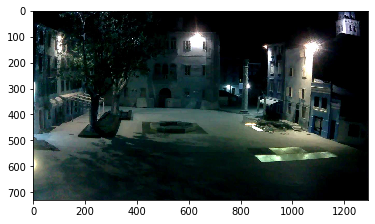

segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3580.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3578.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3579.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3580.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3578.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3579.ts'}
skip segment: {'secs': 12.0, 'segment': 'https://cdn-001.whatsupcams.com/hls/hr_zadar3-3580.ts'}


In [3]:
def collect_frames(chunk_url, count=5): 
    """collects frams making 'count' requests for chunks
    
    args:
        count : the number of chunks to fetch
    return: 
        list of frames
        
    """
    cams_base = video.extract_base(chunk_url)
    collected_segment = collections.deque(maxlen=10)
    crop_frames = list()
    
    for idx in range(count):
        cams_response = requests.get(chunk_url)
        cams_chunklist = cams_response.text
        segments = video.m3u8_segments(cams_chunklist, cams_base)

        for segment in segments:
            # only get the first frame 
            if segment not in collected_segment:
                frame = video.display_frame(segment)
                crop_frames.append(frame[0])
                print("segment:", segment)
                collected_segment.append(segment)
            else:
                print("skip segment:",segment)
    return crop_frames

CROP_FRAMES = collect_frames(M3U8, 5)

type(crop_frames[2])

image_encoded = video.encode_img(Image.fromarray(frame[0], 'RGB'))
img_raw = video.decode_img(image_encoded)


## Select the image to define the crop region

In [4]:
class image_select():
    """select a frame from a list of frames that are displayed.
    
    Note:
        - selected frame can used to define crop region.
        - must select the crop button to commit your frame selection
    """
    def __init__(self, crop_frames):
        """display selection of images, select one to be used fro crop definition """
        self.title_widget = widgets.Label(value="browse / select image to crop", layout={'border': '1px solid green','width':'61%'})
        self.image_widget = widgets.Output(layout={'border': '1px solid red','width':'61%','height':'270pt'})
        self.bck_button= widgets.Button(description="<",layout={'width':'20%'})
        self.crp_button= widgets.Button(description="crop",layout={'width':'20%'})
        self.fwd_button= widgets.Button(description=">",layout={'width':'20%'})
        self.crop_frames = crop_frames
        self.frame_idx = 0
        self.frame_selected_callback = None

    def display_image(self, image, image_widget):
        """convert from np array to image
           :param idx: index into frame 

        """
        image_encoded = video.encode_img(Image.fromarray(image, 'RGB'))
        img_raw = video.decode_img(image_encoded) 
        with image_widget:
            display(img_raw)
            clear_output(wait=True)

    def image_update(self, inc):
        if self.frame_idx + inc >= 0 and self.frame_idx + inc < len(self.crop_frames):
            self.frame_idx += inc
            self.title_widget.value = "Viewing image #{}".format(self.frame_idx)
            self.display_image(self.crop_frames[self.frame_idx], self.image_widget)


    def bckfwd_click(self, b):
        self.image_update(1 if b.description == '>' else -1)

    def crop_click(self, b):
        self.fwd_button.disabled = True
        self.bck_button.disabled = True
        self.frame_selected_callback(self.frame_idx)

    def ignition(self, frame_selected_callback):
        self.frame_selected_callback = frame_selected_callback
        self.crp_button.on_click(self.crop_click)
        self.fwd_button.on_click(self.bckfwd_click)
        self.bck_button.on_click(self.bckfwd_click)

        buttons = widgets.HBox([self.bck_button, self.crp_button, self.fwd_button])
        dashboard = widgets.VBox([self.title_widget, self.image_widget, buttons])
        display(dashboard)
        self.image_update(0)

        
def frame_selected(idx):
    global FRAME_IDX
    print("Use frame {} to work out cropping region.".format(idx))
    FRAME_IDX = idx
    
imgsel = image_select(CROP_FRAMES)
imgsel.ignition(frame_selected)


Use frame 3 to work out cropping region.


## Define crop region using the selected image.
#### Use  'Save Crop Sizes' when you're satisfied with the crop region.

In [ ]:
FRAME_IDX

In [5]:

SHAPE = None
def grabCropShape(image_name, shape):
    global SHAPE
    SHAPE = shape
    print("set SHAPE ", image_name, shape, flush=True)

try :
    print("Using frame #{} to specify crop region.".format(FRAME_IDX))
    crop([CROP_FRAMES[FRAME_IDX]], callback=grabCropShape)
except NameError as e:
    print("You must select the 'crop' button above to commit your selection.")
crop([CROP_FRAMES[FRAME_IDX]], callback=grabCropShape)

Using frame #3 to specify crop region.


GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

## Show collected frames using the defined  crop region

In [7]:
def crop_frame(frame, crop_specification):
    region_of_interest = (crop_specification.size[0],
                        crop_specification.size[1],
                        crop_specification.size[0]+crop_specification.size[2],
                        crop_specification.size[1]+crop_specification.size[3])
    orginal_encoded = video.encode_img(Image.fromarray(frame, 'RGB'))
    img_raw = video.decode_img(orginal_encoded)
    cropped = img_raw.crop(region_of_interest)
    image_encoded = video.encode_img(cropped)
    return image_encoded
        
def collected_frames(crop_frames):
    crop_label = widgets.Label(layout={'border': '1px solid green','width':'61%'})
    crop_widget = widgets.Output(layout={'border': '1px solid green','width':'61%','height':'270pt'})
    display(VBox([crop_label, crop_widget]))
    crop_label.value = "Review {} cropped images.".format(len(crop_frames))  

    for idx in range(len(crop_frames)):
        with crop_widget:
            time.sleep(1)
            img = crop_frame(crop_frames[idx], SHAPE)
            display(video.decode_img(img))
            crop_label.value = "{} of {}".format(idx+1, len(crop_frames) )
            clear_output(wait=True)

            
if SHAPE is None:
    print("\n\nYou must select the 'Save Crop Sizes' button above to commit crop region.\n\n")
else:
    print("Using shape : {}".format(SHAPE))
    collected_frames(CROP_FRAMES)

Using shape : <interactivecrop.shapes.Rectangle object at 0x12b39af98>


In [8]:
%%script false --no-raise-error


def show_frame(frame):
    image_encoded = video.encode_img(Image.fromarray(frame, 'RGB'))
    img_raw = video.decode_img(image_encoded)
    clear_output(wait=True)
    plt.imshow(img_raw)
    plt.show()

def frame_crop(frame):
    cropped_img = crop_frame(frame, SHAPE)
    clear_output(wait=True)
    display(video.decode_img(cropped_img))

    
def fetch_frames(segment, frame_modulo=24, process_frame=show_frame):
    cap = cv2.VideoCapture(segment['segment'])
    count = 0
    frames = list()
    if (cap.isOpened()):
        while True:
            ret, frame = cap.read()
            if ret is False:
                print("end frame : {}", count)
                return frames
            if count % frame_modulo == 0:
                frames.append(frame)
                process_frame(frame)
                print("{} in {}".format(count, segment))
            count += 1
    else:
        print("Open failed....")
    return frames

In [9]:
%%script false --no-raise-error

displayed_segment = collections.deque(maxlen=10)
for idx in range(10):
    cams_response = requests.get(cams_chunk_url)
    cams_chunklist = cams_response.text
    #print(whatsupcams_chunklist)
    segments = video.m3u8_segments(cams_chunklist, cams_base)
    #print("loop idx : {}, segments:{} ".format(idx, len(segments)))
    time.sleep(1)
    for segment in segments:
        if segment not in displayed_segment:
        # only get the first frame 
            #frames = fetch_frames(segment, process_frame=show_frame)
            frames = fetch_frames(segment, process_frame=frame_crop)
            displayed_segment.append(segment)
        else:
            print("skip segment:{}".format(segment))
        

In [10]:
%%script false --no-raise-error

stream_label = widgets.Label(layout={'border': '1px solid green','width':'61%'})
stream_widget = widgets.Output(layout={'border': '1px solid red','width':'61%','height':'270pt'})
stream_status = widgets.Label(layout={'border': '1px solid green','width':'61%'})
transmit_button = widgets.Button(description="Transmit to Streams",layout={'width':'30%'})
stop_button = widgets.Button(description="Stop Collecting frames",layout={'width':'30%'})
button_bar = widgets.HBox([transmit_button, stop_button])

display(VBox([stream_label, stream_widget, button_bar, stream_status]))
#stream.value = "Review {} cropped images.".format(len(crop_frames))  

def stop_clicked(b):
    print("stop")
    
def transmit_clicked(b):
    print("transmit")
    
stop_button.on_click(stop_clicked)
transmit_button.on_click(transmit_clicked)

displayed_segment = collections.deque(maxlen=10)

for idx in range(10):
    cams_response = requests.get(cams_chunk_url)
    cams_chunklist = cams_response.text
    #print(whatsupcams_chunklist)
    segments = video.m3u8_segments(cams_chunklist, cams_base)
    #print("loop idx : {}, segments:{} ".format(idx, len(segments)))
    time.sleep(1)
    for segment in segments:
        if segment not in displayed_segment:
        # only get the first frame 
            #frames = fetch_frames(segment, process_frame=show_frame)
            frames = fetch_frames(segment, process_frame=frame_crop)
            displayed_segment.append(segment)
        else:
            print("skip segment:{}".format(segment))


In [11]:
%%script false --no-raise-error


def show_frame(frame):
    image_encoded = video.encode_img(Image.fromarray(frame, 'RGB'))
    img_raw = video.decode_img(image_encoded)
    clear_output(wait=True)
    plt.imshow(img_raw)
    plt.show()

def frame_crop(frame):
    cropped_img = crop_frame(frame, SHAPE)
    clear_output(wait=True)
    display(video.decode_img(cropped_img))

    
def fetch_frames(segment, frame_modulo=24, process_frame=show_frame, status_display=None):
    cap = cv2.VideoCapture(segment['segment'])
    count = 0
    frames = list()
    if (cap.isOpened()):
        while True:
            ret, frame = cap.read()
            if ret is False:
                if status_display is not None: status_display.value = "ENDFrame @ {}".format(count)
                return frames
            if count % frame_modulo == 0:
                frames.append(frame)
                process_frame(frame)
                if status_display is not None: status_display.value = "{} in {}".format(count, segment)
            count += 1
    else:
        print("Open failed....")
    return frames

In [12]:
%%script false --no-raise-error

displayed_segment = collections.deque(maxlen=10)
for idx in range(10):
    cams_response = requests.get(cams_chunk_url)
    cams_chunklist = cams_response.text
    #print(whatsupcams_chunklist)
    segments = video.m3u8_segments(cams_chunklist, cams_base)
    #print("loop idx : {}, segments:{} ".format(idx, len(segments)))
    time.sleep(1)
    for segment in segments:
        if segment not in displayed_segment:
        # only get the first frame 
            #frames = fetch_frames(segment, process_frame=show_frame)
            frames = fetch_frames(segment, process_frame=frame_crop)
            displayed_segment.append(segment)
        else:
            print("skip segment:{}".format(segment))
        

### create a dashboard

In [13]:

class stream_cropped_video():

    def stop_clicked(self, b):
        self.stream_action.value = "STOP"
        self.stop = True
    
    def transmit_clicked(self, b):
        stream_action.value = "TO STREAM"

    
        
    def __init__(self, cams_chunk_url=None, shape=None):
        self.cams_chunk_url = cams_chunk_url
        self.cams_base = cams_base = video.extract_base(cams_chunk_url)
        self.shape = shape
        
        self.stream_action = widgets.Label(layout={'border': '1px solid green','width':'61%'})
        self.stream_widget = widgets.Output(layout={'border': '1px solid red','width':'61%','height':'270pt'})
        self.stream_status = widgets.Label(layout={'border': '1px solid green','width':'61%'})
        self.transmit_button = widgets.Button(description="Transmit to Streams",layout={'width':'30%'})
        self.stop_button = widgets.Button(description="Stop Collecting frames",layout={'width':'30%'})
        self.stop = False
        self.to_streams = False
        
        self.button_bar = widgets.HBox([self.transmit_button, self.stop_button])
        display(VBox([self.stream_action, self.stream_widget, self.button_bar, self.stream_status]))
        
        self.stop_button.on_click(self.stop_clicked)
        self.transmit_button.on_click(self.transmit_clicked)
        
        self.displayed_segment = collections.deque(maxlen=10)


    def frame_crop_display(self, frame):
        """crop frame and display
        
        Note: a crop region may not have been specified 
        """
        if self.shape is not None:
            cropped_img = crop_frame(frame, self.shape)
        else:
            cropped_img = frame
        with self.stream_widget:
            display(video.decode_img(cropped_img))
            clear_output(wait=True)
            
    def fetch_frames(self, segment, frame_modulo=24, process_frame=None):
        cap = cv2.VideoCapture(segment['segment'])
        count = 0
        frames = list()
        if (cap.isOpened()):
            while True:
                ret, frame = cap.read()
                if ret is False:
                    if self.stream_status is not None: self.stream_status.value = "ENDFrame @ {}".format(count)
                    return frames
                if count % frame_modulo == 0:
                    frames.append(frame)
                    process_frame(frame)
                count += 1
        else:
            print("Open failed....")
        return frames
    
    def ignition(self, iterations=2, wait_time=1):
        self.stream_action.value = "Starting...."
        for idx in range(iterations):
            if self.stop is True: break
            cams_response = requests.get(self.cams_chunk_url)
            cams_chunklist = cams_response.text
            segments = video.m3u8_segments(cams_chunklist, self.cams_base)
            time.sleep(wait_time)
            for segment in segments:
                if self.stop is True: break
                if segment not in self.displayed_segment:
                    #self.stream_action.value = "Fetching...."
                    self.stream_action.value = "{} secs of frames in : {}".format(segment['secs'], segment['segment'])
                    frames = self.fetch_frames(segment, process_frame=self.frame_crop_display)
                    self.stream_status.value = "Fetched ... {} frames.".format(len(frames))
                    self.displayed_segment.append(segment)
                else:
                    self.stream_status.value = "skip segment:{}".format(segment)

scv = stream_cropped_video(M3U8, SHAPE)
scv.ignition(iterations=2)
print("done")


done
